In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [4]:
# Read our input data
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [5]:
# Show statistics about some of our features
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_train.drop('vendor_id', axis=1).describe()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.665,-73.973,40.751,-73.973,40.752,959.492
std,1.314,0.071,0.033,0.071,0.036,5237.432
min,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,9.000,-61.336,51.881,-61.336,43.921,3526282.000


In [6]:
# Find the number of longitude outliers
df_train[df_train['pickup_longitude'] < - 74.2].shape[0]

82

In [7]:
# Find the proportion of vendor_id which is vendor 2
(df_train['vendor_id'] == 2).mean()

0.53495026887986374

In [8]:
# Find the proportion of store_and_fwd_flag tht is positive.
(df_train['store_and_fwd_flag'] == 'Y').mean()

0.0055153964915359748

In [10]:
# Convert pickup_datetime to Timestamp
df_train['pickup_dt'] = pd.to_datetime(df_train['pickup_datetime'])
df_test['pickup_dt'] = pd.to_datetime(df_test['pickup_datetime'])

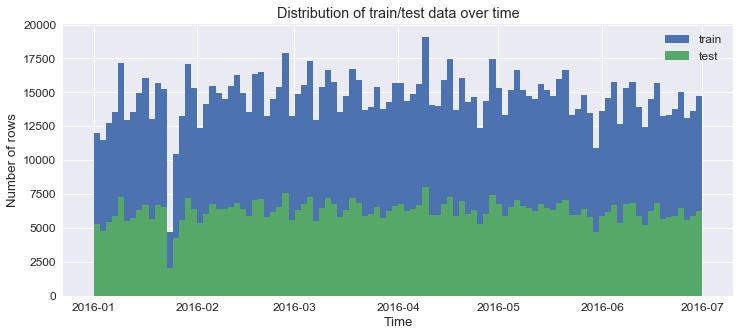

In [11]:
# Plot distribution of the dataset
sns.set(font_scale=1.2)
plt.figure(figsize=(12, 5))
plt.hist([x.to_pydatetime() for x in df_train['pickup_dt']], bins=100, label='train')
plt.hist([x.to_pydatetime() for x in df_test['pickup_dt']], bins=100, label='test')
plt.title('Distribution of train/test data over time')
plt.xlabel('Time')
plt.ylabel('Number of rows')
plt.legend()
plt.show()

In [12]:
# Get the hour of each sample
hours = np.array([t.hour for t in df_train['pickup_dt']])

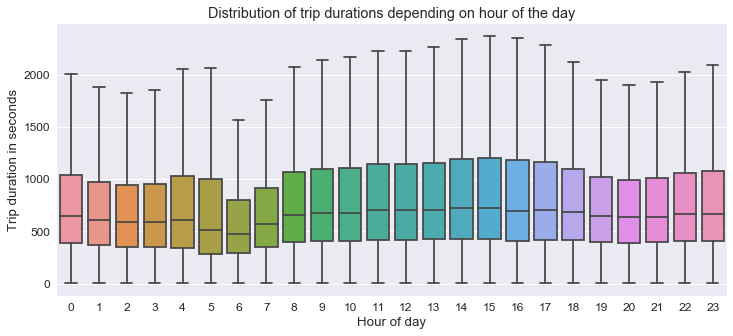

In [13]:
# Plot trip duration distribution based on time of day
sns.set(font_scale=1.2)
plt.figure(figsize=(12, 5))
sns.boxplot(hours, df_train['trip_duration'].values, showfliers=False)
plt.title('Distribution of trip durations depending on hour of the day')
plt.ylabel('Trip duration in seconds')
plt.xlabel('Hour of day')
plt.show()

In [14]:
# Calculate the manhattan distance and speed
manhattan = (np.abs(df_train['pickup_latitude'] - df_train['dropoff_latitude']) + np.abs(df_train['pickup_longitude'] - df_train['dropoff_longitude']))
manhattan_speed = manhattan / df_train['trip_duration']

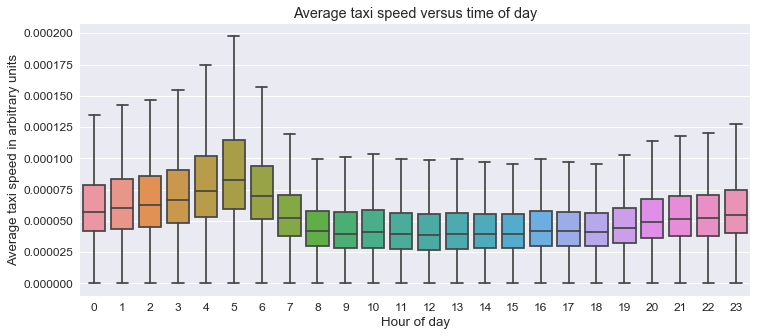

In [15]:
# Plot speed against the time of day
sns.set(font_scale=1.2)
plt.figure(figsize=(12, 5))
sns.boxplot(hours, manhattan_speed, showfliers=False)
plt.title('Average taxi speed versus time of day')
plt.ylabel('Average taxi speed in arbitrary units')
plt.xlabel('Hour of day')
plt.show()

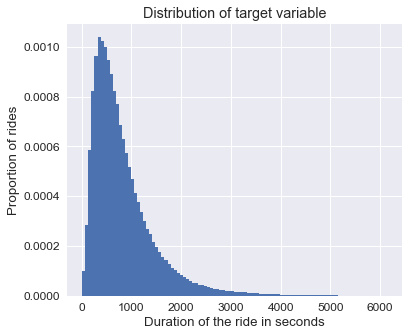

In [32]:
# Plot distribution of the target variable, removing 5K outliers
sns.set(font_scale=1.2)
plt.figure(figsize=(6, 5))
plt.hist(sorted(df_train['trip_duration'])[2500:-2500], bins=100, normed=True)
plt.title('Distribution of target variable')
plt.ylabel('Proportion of rides')
plt.xlabel('Duration of the ride in seconds')
plt.show()

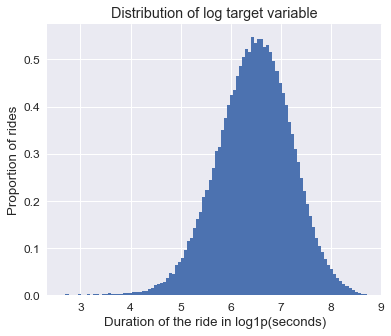

In [33]:
# Plot distribution of the target variable, removing 5K outliers
sns.set(font_scale=1.2)
plt.figure(figsize=(6, 5))
plt.hist(sorted(np.log1p(df_train['trip_duration']))[2500:-2500], bins=100, normed=True)
plt.title('Distribution of log target variable')
plt.ylabel('Proportion of rides')
plt.xlabel('Duration of the ride in log1p(seconds)')
plt.show()

In [17]:
# Calculate the 'predicted' value for the benchmark model
benchmark_val = np.expm1(np.mean(np.log1p(df_train['trip_duration'])))
benchmark_val

642.53628300499236

In [18]:
# Calculate the RMSLE score of the benchmark model
benchmark_score = np.sqrt(np.mean((np.log1p(benchmark_val) - np.log1p(df_train['trip_duration'])) ** 2))
benchmark_score

0.79575923654121561

In [19]:
# Create a submission based on the benchmark model to submit to Kaggle
benchmark_sub = pd.DataFrame({'id': df_test['id'], 'trip_duration': round(benchmark_val, 2)})
benchmark_sub.to_csv('benchmark_submission.csv', index=False)

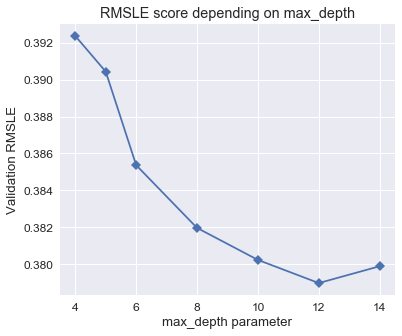

In [23]:
# Scores from optimisation
max_depth = [(4, 0.39236500000000002), (5, 0.39043299999999997), (6, 0.38536500000000001), (8, 0.381965), (10, 0.38023099999999999), (12, 0.37897700000000001), (14, 0.379888)]
colsample_bylevel = [(1, 0.37926599999999999), (0.9, 0.37897700000000001), (0.8, 0.37967600000000001), (0.7, 0.37894299999999997)]
subsample = [(1, 0.37879800000000002), (0.9, 0.37894299999999997), (0.8, 0.38037900000000002), (0.7, 0.381635)]
min_child_weight = [(0.5, 0.37879800000000002), (1, 0.37879800000000002), (2, 0.37919900000000001), (3, 0.380025)]

sns.set(font_scale=1.2)
plt.figure(figsize=(6, 5))
plt.plot(*zip(*max_depth), marker='D')
plt.title('RMSLE score depending on max_depth')
plt.ylabel('Validation RMSLE')
plt.xlabel('max_depth parameter')
plt.show()

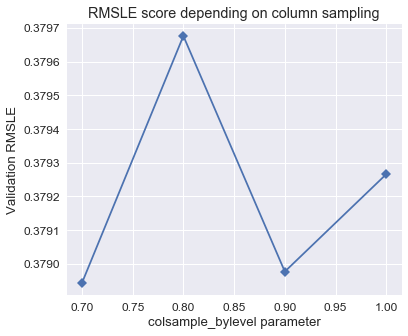

In [24]:
sns.set(font_scale=1.2)
plt.figure(figsize=(6, 5))
plt.plot(*zip(*colsample_bylevel), marker='D')
plt.title('RMSLE score depending on column sampling')
plt.ylabel('Validation RMSLE')
plt.xlabel('colsample_bylevel parameter')
plt.show()

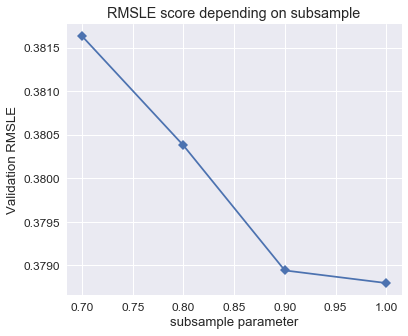

In [25]:
sns.set(font_scale=1.2)
plt.figure(figsize=(6, 5))
plt.plot(*zip(*subsample), marker='D')
plt.title('RMSLE score depending on subsample')
plt.ylabel('Validation RMSLE')
plt.xlabel('subsample parameter')
plt.show()

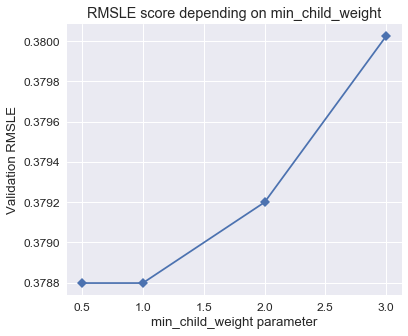

In [26]:
sns.set(font_scale=1.2)
plt.figure(figsize=(6, 5))
plt.plot(*zip(*min_child_weight), marker='D')
plt.title('RMSLE score depending on min_child_weight')
plt.ylabel('Validation RMSLE')
plt.xlabel('min_child_weight parameter')
plt.show()

In [8]:
# Load in our trained model
from sklearn.cross_validation import train_test_split
import xgboost as xgb
import pickle
bst = xgb.Booster()
bst.load_model('code/model_optim.mdl')

In [10]:
# Get validation data
x_train, x_test, y_train, id_test = pickle.load(open('code/engineered_data.bin', 'rb'))

# First we take the log1p of the target value
y_train = np.log1p(y_train)

# We split off a validation set
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=1337)

In [11]:
# Predict on validation set
p_valid = bst.predict(xgb.DMatrix(x_valid))

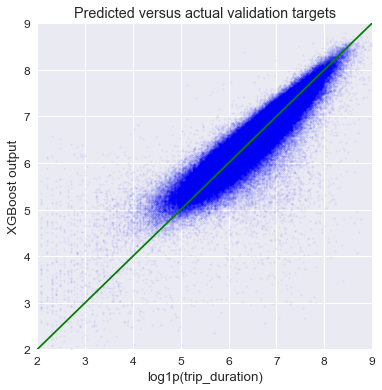

In [63]:
sns.set(font_scale=1.2)
plt.figure(figsize=(6, 6))
plt.scatter(y_valid, p_valid, s=3, color='blue', alpha=0.05)
plt.plot([1,9],[1,9], color='green')
plt.title('Predicted versus actual validation targets')
plt.xlabel('log1p(trip_duration)')
plt.ylabel('XGBoost output')
axes = plt.gca()
axes.set_xlim([2, 9])
axes.set_ylim([2, 9])
plt.show()
plt.show()

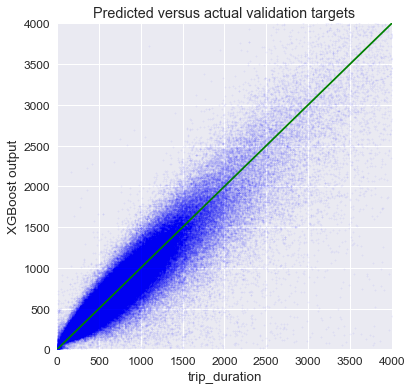

In [60]:
sns.set(font_scale=1.2)
plt.figure(figsize=(6, 6))
plt.scatter(np.expm1(y_valid), np.expm1(p_valid), s=2, color='blue', alpha=0.05)
plt.plot([1,6000],[1,6000], color='green')
plt.title('Predicted versus actual validation targets')
plt.xlabel('trip_duration')
plt.ylabel('XGBoost output')
axes = plt.gca()
axes.set_xlim([0, 4000])
axes.set_ylim([0, 4000])
plt.show()

In [74]:
# Added required data to the dataframe
x_valid['hour'] = (x_valid['daily_minute'] / 60).astype(np.int)
x_valid['real'] = y_valid
x_valid['predicted'] = p_valid

In [83]:
# Calculate score for each hour
def rmse(x):
    return np.sqrt(np.mean((x['real'] - x['predicted']) ** 2))
scores = x_valid.groupby('hour').apply(rmse)

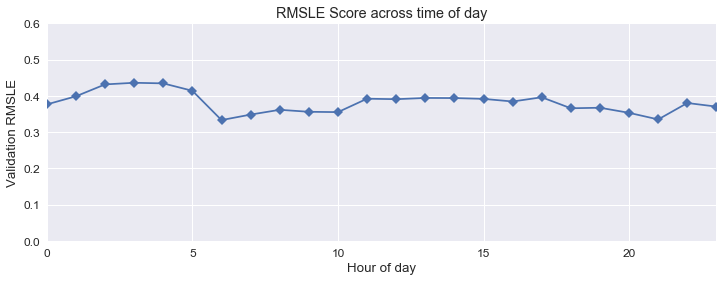

In [95]:
sns.set(font_scale=1.2)
plt.figure(figsize=(12, 4))
plt.plot(scores, marker='D')
plt.title('RMSLE Score across time of day')
plt.xlabel('Hour of day')
plt.ylabel('Validation RMSLE')
ax=plt.gca()
plt.ylim([0, 0.6])
plt.xlim([0, 23])
plt.show()

In [104]:
# Caluclate proportion of samples predicted within 20% of the true value
((np.abs(np.expm1(p_valid) - np.expm1(y_valid)) / np.expm1(y_valid)) < 0.2).mean()

0.59395877680998466

In [105]:
# Same as above, but for the benchmark model
((np.abs(642.54 - np.expm1(y_valid)) / np.expm1(y_valid)) < 0.2).mean()

0.21567962046968248

In [116]:
# Get importances from the xgboost model
importances = bst.get_fscore()
print(importances)
importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

{'unix_time': 192320, 'angle': 122359, 'dist_l1': 132531, 'dist_l2': 105555, 'dropoff_longitude': 185650, 'store_and_fwd_flag': 1680, 'vendor_id': 69018, 'pickup_longitude': 289380, 'daily_count': 94653, 'delta_lat': 92850, 'hourly_count': 109511, 'dist_haversine': 88277, 'haversine_speed_estim': 114336, 'daily_minute': 165165, 'delta_lon': 91975, 'day_of_week': 46283, 'passenger_count': 86228, 'pickup_latitude': 237460, 'dropoff_latitude': 169032}


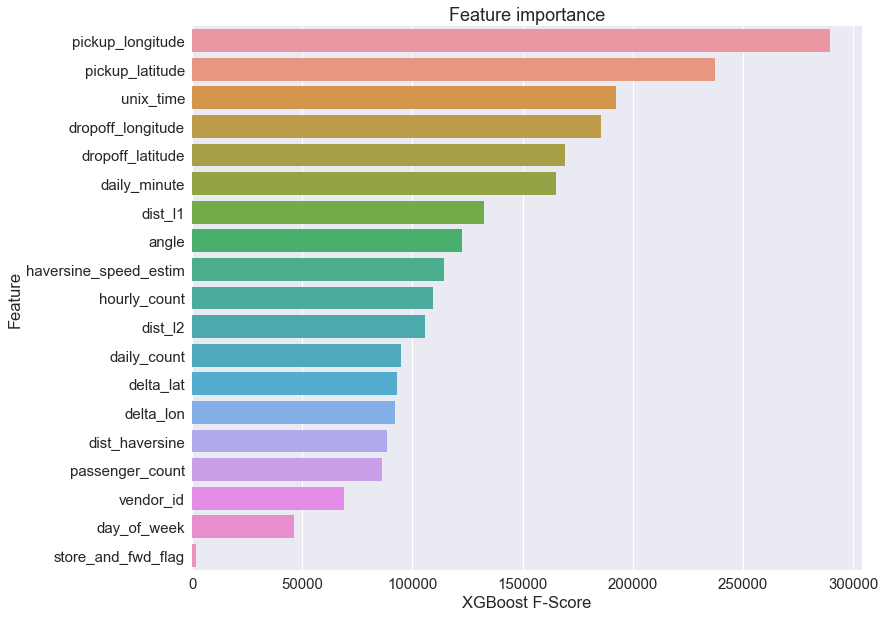

In [123]:
# Plot importances
sns.set(font_scale=1.5)
plt.figure(figsize=(12, 10))
sns.barplot(x=zip(*importances)[1], y=zip(*importances)[0])
plt.title('Feature importance')
plt.ylabel('Feature')
plt.xlabel('XGBoost F-Score')
plt.show()